In [8]:
import subprocess
import tempfile
import imageio.v3 as iio
import cv2
import numpy as np
import os

from cv2.typing import Size
from matplotlib import pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from tqdm.auto import tqdm

from scripts.main import timing
from steps.image_row_builder import construct_rows
from steps.video_camera_motion import VideoMotion

In [2]:
ROOT = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input/GX010014.MP4"
Y1 = 550
Y2 = 1900
X1 = 1350
X2 = 2650
samples = 1000
PADDING = 300

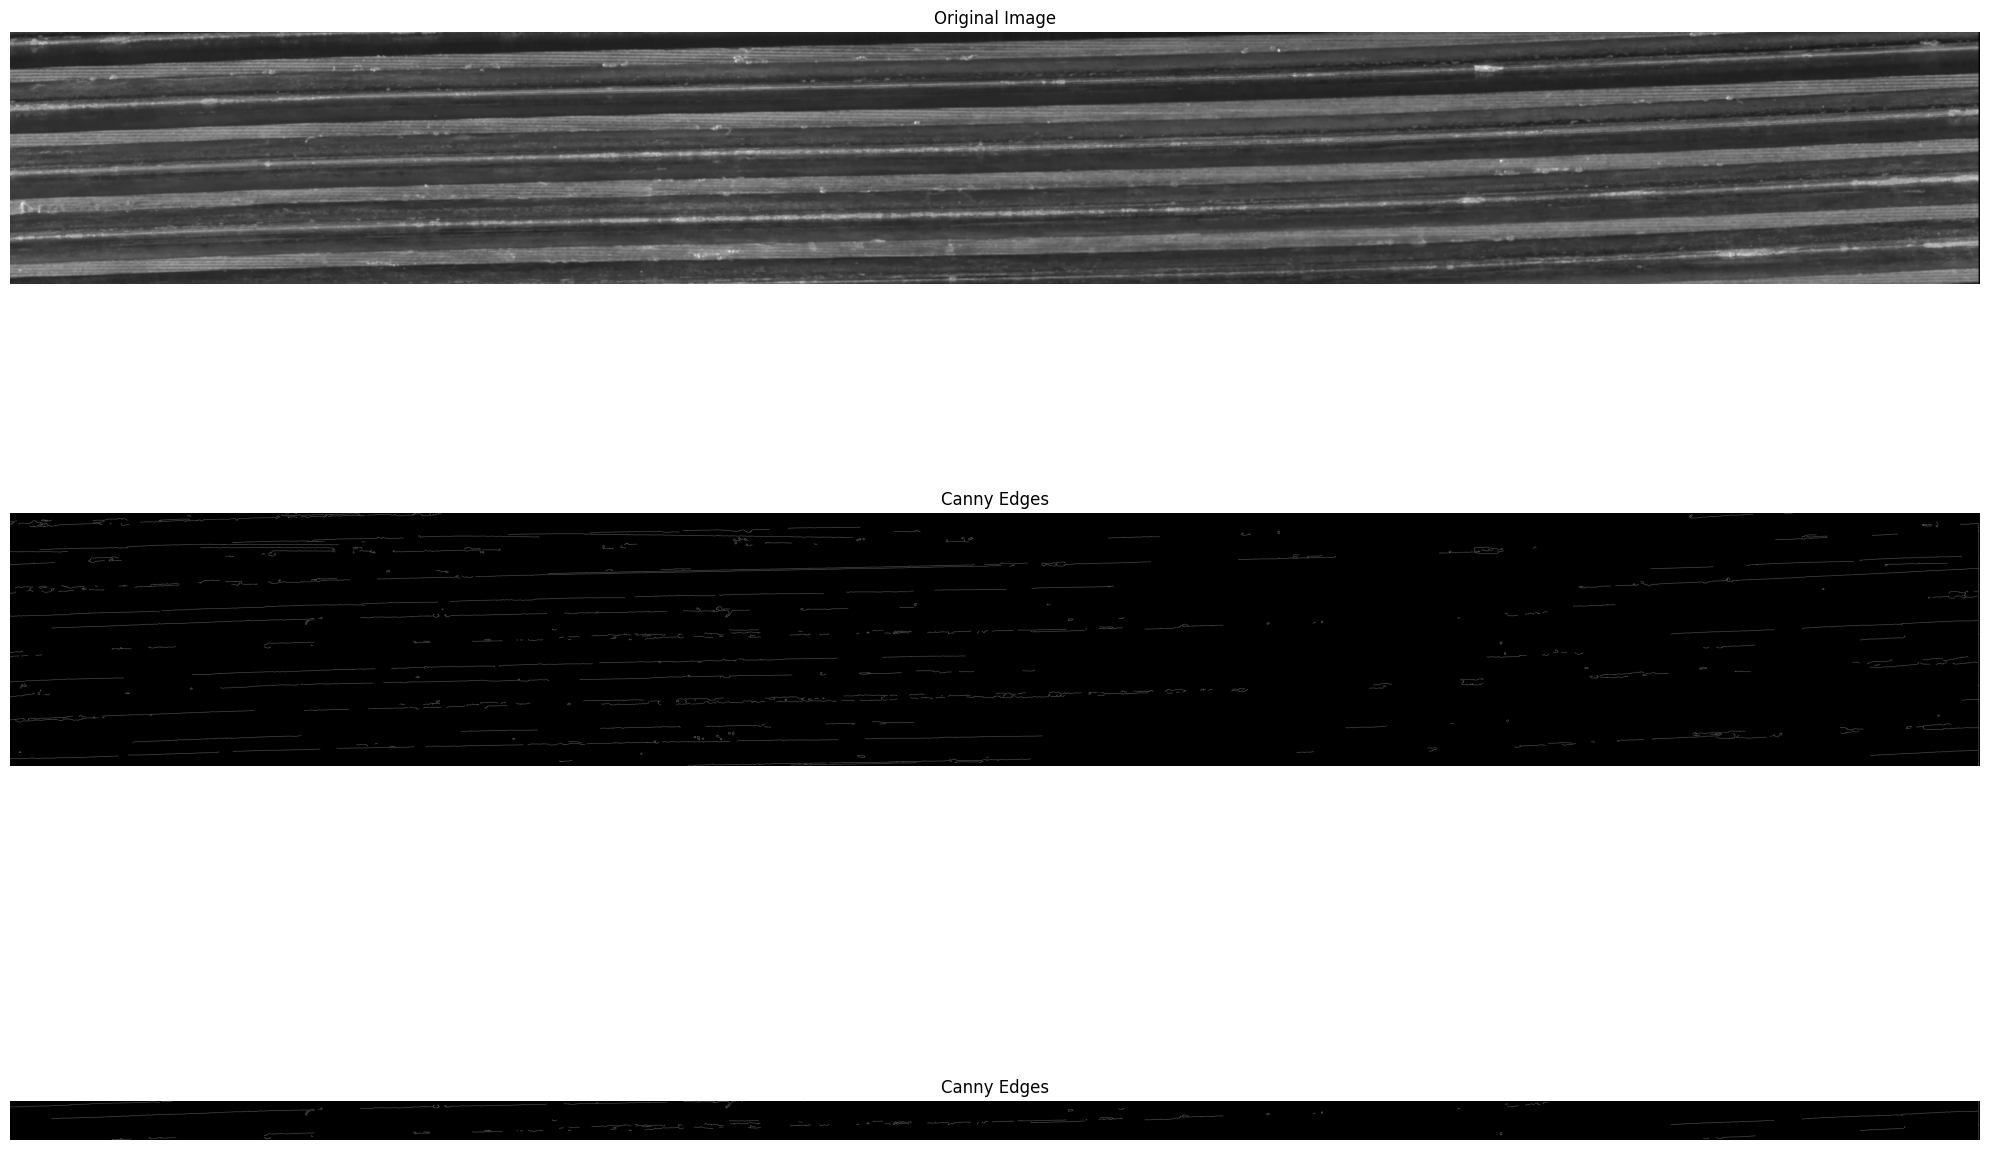

In [44]:
# Load an image
image_path = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/GX010010_preprocessed-oio-1.png"  # Replace with the path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
image = cv2.GaussianBlur(image, (15, 15), 0)  # Kernel size (5, 5)

# Apply Canny edge detection
low_threshold = 10
high_threshold = 100
edges = cv2.Canny(image, low_threshold, high_threshold)

closed_edges = edges
# kernel = np.ones((5, 51), np.uint8)  # Define a 5x5 kernel
# closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_CLOSE, kernel)
# 
# kernel = np.ones((3 ,3), np.uint8)  # Define a 5x5 kernel
# closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_ERODE, kernel)

# Display the original and edge-detected images
plt.figure(figsize=(20, 16))

# Original image
plt.subplot(3, 1, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Edges
plt.subplot(3, 1, 2)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(edges[500:700], cmap='gray')
plt.title("Canny Edges")
plt.axis("off")

plt.tight_layout()
plt.show()


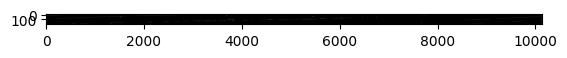

In [43]:
edges[:, 0:100].

In [28]:
def winPathToUnixPath(path):
    return path.replace("\\", "/").replace("C:/", "/mnt/c/")

In [4]:
vidcap = cv2.VideoCapture(ROOT)
vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

3165.0

In [5]:
frames = []
start = 2460
step = 1
amount = 10
end = start + step*amount
for i in range(start, end, step):
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = vidcap.read()
    frames.append(frame)


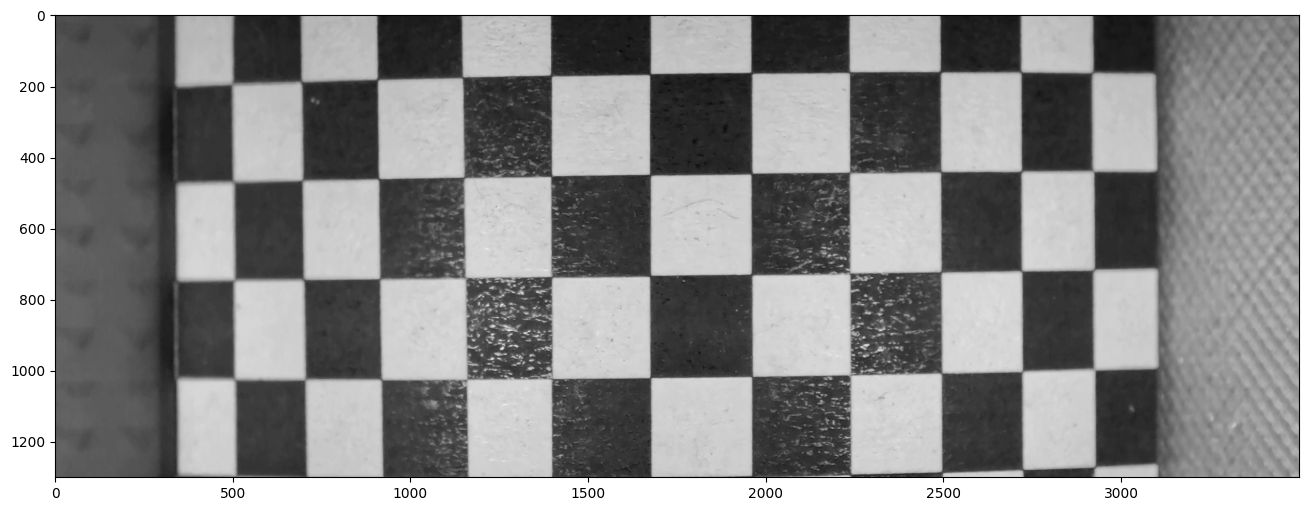

In [75]:
plt.figure(figsize=(22, 6))
frame = cv2.imread('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/GX010014-oio.png')[:, 2500:6000]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# frame = np.where(frame < 170, 0, 255).astype(np.uint8)
# kernel = np.ones((7, 7), np.uint8)
# frame = cv2.morphologyEx(frame, cv2.MORPH_OPEN, kernel)
# frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, kernel)

# kernel = np.ones((3,3),np.uint8)
# frame = cv2.dilate(frame,kernel,iterations = 1)
plt.imshow(frame, cmap='gray')

# plt.hist(frame.ravel(), 256)
plt.show()
plt.close()

In [73]:
# Define the dimensions of the checkerboard
CHECKERBOARD = (3, 3)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# vidcap = cv2.VideoCapture('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/for_calibration.mp4')

objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

ret, corners = cv2.findChessboardCorners(frame, CHECKERBOARD, None)
# print(ret, corners)
if ret:
    print(ret)
    objpoints.append(objp)
    corners = cv2.cornerSubPix(frame, corners, (11, 11), (-1, -1), criteria)
    imgpoints.append(corners)
    frame2 = cv2.drawChessboardCorners(frame, CHECKERBOARD, corners, ret)
    plt.figure(figsize=(16, 8))
    plt.imshow(frame2, cmap='gray')
    plt.show()

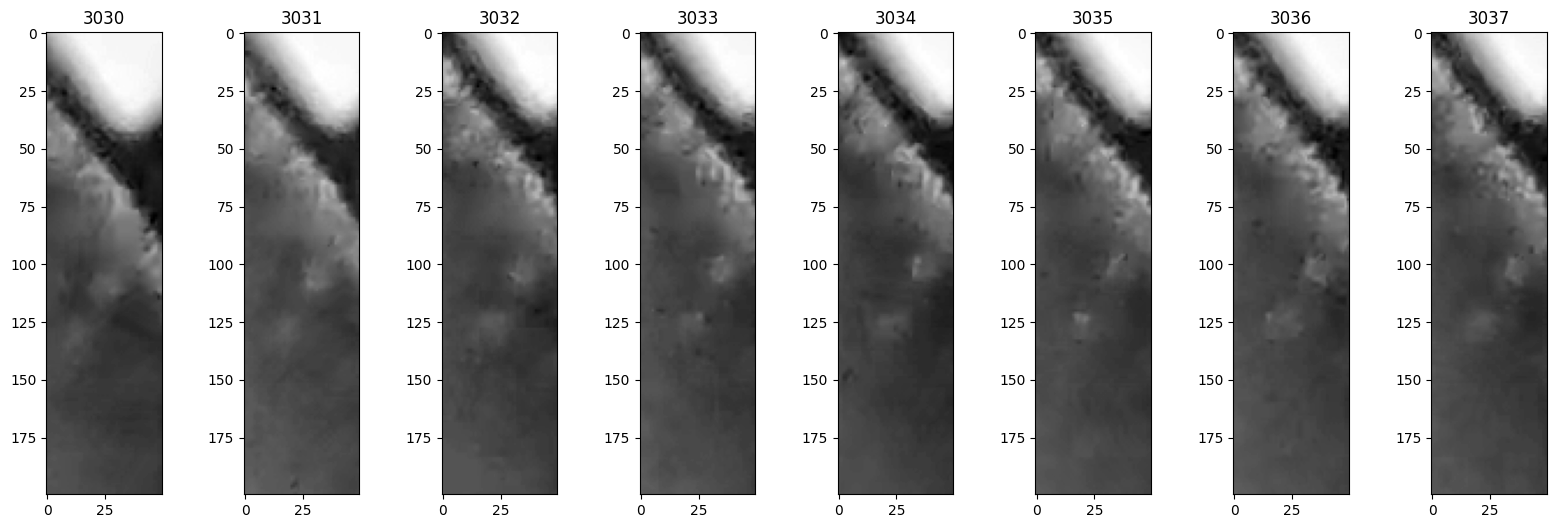

In [37]:
plt.figure(figsize=(20, 6))
for i, frame in enumerate(frames):
    ax = plt.subplot(1, len(frames), i+1)
    ax.imshow(frame[1000:1200, 2000:2050,0], cmap="gray")
    ax.set_title(start + step*i)
plt.show()

In [ ]:
plt.figure(figsize=(20, 60))
for i, frame in enumerate(frames):
    ax = plt.subplot(len(frames), 1, i+1)
    ax.imshow(frame, cmap="gray")
    ax.set_title(start + step*i)
plt.show()

In [5]:
breakpoints = [(49, 240), (870, 1530), (2250, 3031)] #280..2x3 240..3x3 230..2x5

In [99]:
frames = []

for start, end in breakpoints:
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
    success, frame = vidcap.read()
    while success and vidcap.get(cv2.CAP_PROP_POS_FRAMES) <= end:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = np.where(frame < 170, 0, 255).astype(np.uint8)
        frames.append(frame)
        success, frame = vidcap.read()

vidcap.release()

In [18]:
frame_angles = []
hists = []

vidcap = cv2.VideoCapture(ROOT)

frame_rate = 1

total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in tqdm(range(830, 1570, frame_rate),  desc="Processing frames"):
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = vidcap.read()
    undistorted =  frame[Y1:Y2, X1:X2, 0]
    undistorted = cv2.resize(undistorted, (undistorted.shape[0]//4, undistorted.shape[1]//4))
    otsu_threshold, _ = cv2.threshold(undistorted, 0, 255, cv2.THRESH_OTSU)
    
    with tempfile.NamedTemporaryFile(suffix=".pgm", delete=False) as tmpfile:
        filename = tmpfile.name
        iio.imwrite(tmpfile.name, undistorted)  # this must be a grayscale image
        
        output_path = tmpfile.name.replace(".pgm", ".txt")
        
        process = subprocess.Popen(
            ["wsl", "devernay", winPathToUnixPath(tmpfile.name),
             "-t", winPathToUnixPath(output_path),
             "-l", f"{otsu_threshold / 15}",
             "-h", f"{otsu_threshold / 3}",
             # "-p", f"/mnt/c/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/sample{i}.pdf",
             "-s", f"1"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        tmpfile.close()
        
    # Wait for the process to complete and get stdout and stderr
    stdout, stderr = process.communicate()
    
    # Check for errors in stderr
    if stderr:
        print("Error running devernay:", stderr.decode("utf-8"))
    if os.path.exists(output_path):
        with open(output_path, 'r') as output_file:
            result = output_file.read()
    else:
        print(f"Output file {output_path} does not exist.")

    lines = result.split("\n")
    dev = []
    for line in lines:
        if line != "":
            x, y = line.split(' ')
            dev.append((float(x), float(y)))
    dev = np.array(dev)
    if len(dev) == 0:
        print("Something wrong happen")
    choice = np.random.randint(0, len(dev), samples)
    xx0 = np.matmul(dev[choice, 0].reshape(-1, 1), np.ones((1, len(choice))))
    yy0 = np.matmul(dev[choice, 1].reshape(-1, 1), np.ones((1, len(choice))))
    xx1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 0].reshape(1, -1))
    yY1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 1].reshape(1, -1))
    valid = np.zeros_like(xx0, dtype=bool)
    valid[xx0 != xx1] = 1
    angles = np.zeros_like(xx0, np.float32)
    angles[xx0 == xx1] = np.pi / 2
    angles[valid] = np.arctan((yy0[valid] - yY1[valid]) / (xx0[valid] - xx1[valid])).reshape(-1)
    angles[np.eye(samples, dtype=bool)] = np.nan

    filtered = np.rad2deg(np.abs(angles[~np.isnan(angles)]))

    if filename is not None and os.path.exists(filename):
        os.remove(filename)

    # counts, values = np.histogram(filtered, bins=samples)
    hists.append(filtered)
    # frame_angles.append(values[np.argmax(counts)])

Processing frames:   0%|          | 0/740 [00:00<?, ?it/s]

In [32]:
frame_angles_smoothed = []
for hist in hists:
    counts, values = np.histogram(hist, bins=samples)
    # counts = gaussian_filter1d(counts, sigma=2)
    max_index = np.argmax(counts)
    frame_angles_smoothed.append(values[max_index])

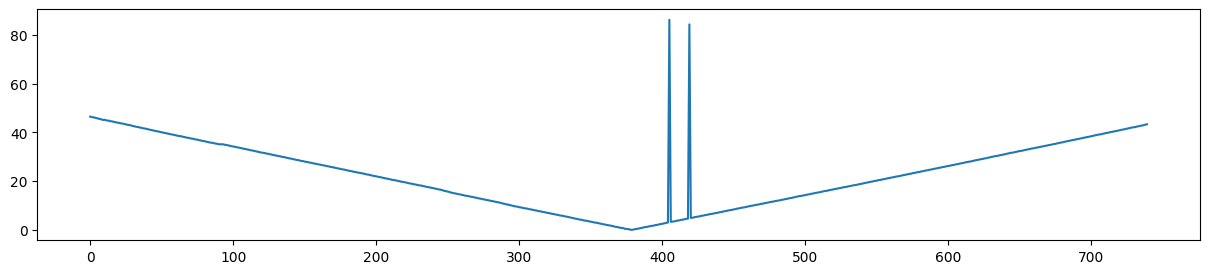

In [33]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [34]:
frame_angles_smoothed_smoothed = savgol_filter(frame_angles_smoothed, window_length=8, polyorder=1)  # Adjust window_length and polyorder based on your data

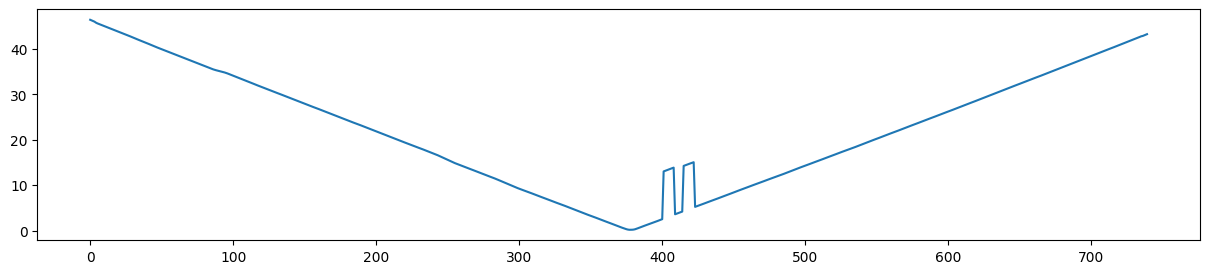

In [35]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed_smoothed)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [36]:
derivative = np.diff(frame_angles_smoothed_smoothed)
threshold = 0.04 # Adjust this threshold based on your data

segment_type = np.zeros_like(derivative)  # Array to store classification: -1 for decreasing, 0 for constant, 1 for increasing

segment_type[derivative > threshold] = 1  # Increasing
segment_type[derivative < -threshold] = -1  # Decreasing
# Constant parts are already set to 0


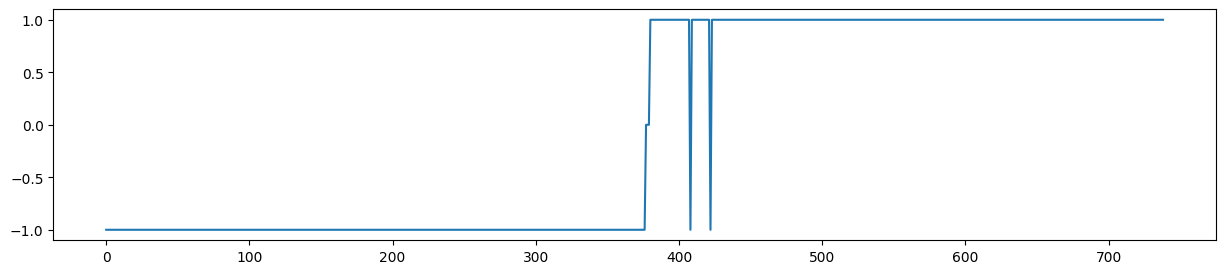

In [37]:
plt.figure(figsize=(15,3))
plt.plot(segment_type)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [43]:
breakpoints = np.where(np.diff(segment_type) != 0)[0] + 1  # +1 because np.diff shifts indices by 1

In [44]:
threshold = 10
step = 1
# Define the distance threshold to group close breakpoints

merged_breakpoints = []

# Temporary group for close breakpoints
current_group = [breakpoints[0]]

# Iterate over the breakpoints
for i in range(1, len(breakpoints)):
    # print(breakpoints[i], breakpoints[i - 1], breakpoints[i] - breakpoints[i - 1] <= threshold)
    # If the difference between consecutive breakpoints is below the threshold, group them
    if breakpoints[i] - breakpoints[i - 1] <= threshold:
        current_group.append(breakpoints[i])
    else:
        # If a current group is finished, calculate the rounded average and store it
        avg_breakpoint = int(round(np.mean(current_group)))
        merged_breakpoints.append(avg_breakpoint)
        # Start a new group
        current_group = [breakpoints[i]]

# Handle the last group
if current_group:
    avg_breakpoint = int(round(np.mean(current_group)))
    merged_breakpoints.append(avg_breakpoint)

# print(np.asarray(merged_breakpoints))

if len(merged_breakpoints) > 1:
    if stats.mode(segment_type[:merged_breakpoints[0]//step])[0] == stats.mode(segment_type[merged_breakpoints[0]//step:merged_breakpoints[1]//step])[0]:
        new_merged_breakpoints = []
    else:
        new_merged_breakpoints = [merged_breakpoints[0]]

    for i in range(1, len(merged_breakpoints) - 1):
        # print(i, stats.mode(self.segment_type[merged_breakpoints[i - 1]:merged_breakpoints[i]])[0], stats.mode(self.segment_type[merged_breakpoints[i]:merged_breakpoints[i + 1]])[0])
        if not stats.mode(segment_type[merged_breakpoints[i - 1]//step:merged_breakpoints[i]//step])[0] == stats.mode(segment_type[merged_breakpoints[i]//step:merged_breakpoints[i + 1]//step])[0]:
            new_merged_breakpoints.append(merged_breakpoints[i])

    if not stats.mode(segment_type[merged_breakpoints[-1]//step:])[0] == stats.mode(segment_type[merged_breakpoints[-2]//step:merged_breakpoints[-1]//step])[0]:
        new_merged_breakpoints.append(merged_breakpoints[-1])

new_merged_breakpoints = np.concatenate([[0], new_merged_breakpoints, [(len(frame_angles_smoothed) - 1) * step]])
# Now merged_breakpoints contains the final list of unique breakpoints
print("Merged Breakpoints:", new_merged_breakpoints)


Merged Breakpoints: [  0 378 739]


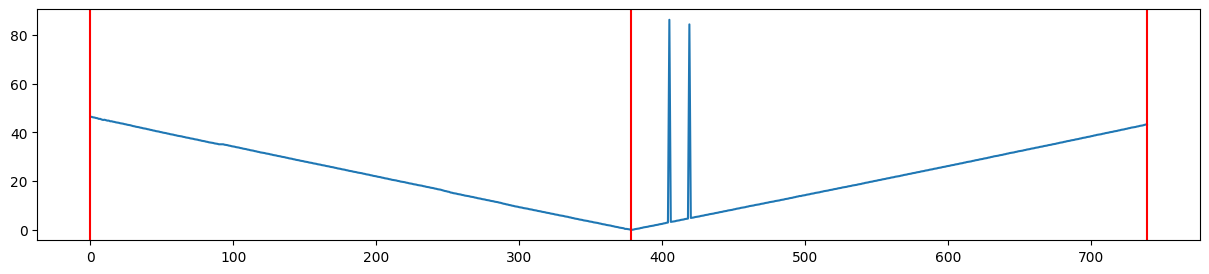

In [45]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed)
# plt.plot(segment_type)
for bp in new_merged_breakpoints:
    plt.axvline(bp, color="red")
plt.show()

In [46]:
borderBreakpoints = []
for i in range(0, len(new_merged_breakpoints) - 1):
    if stats.mode(segment_type[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]])[0] == 0:
        borderBreakpoints.append([new_merged_breakpoints[i], new_merged_breakpoints[i + 1]])

print(f"Calculated: Border Breakpoints\n"
      f"{np.asarray(borderBreakpoints)}\n")

Calculated: Border Breakpoints
[]



0 0 0 0 -1.0
1 0 0 0 1.0


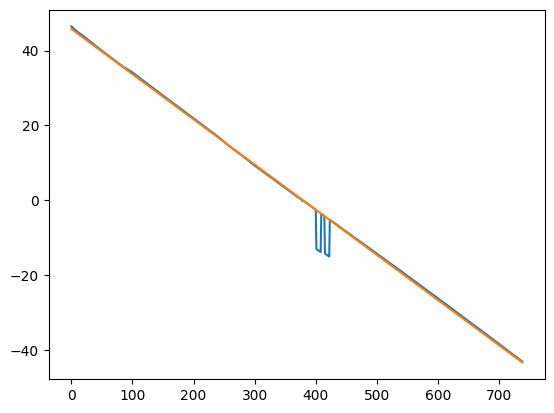

Calculated : RotationPerFrame
0.1208546132240544


In [56]:
fa = []
j = 0
k = 0
for i in range(0, len(new_merged_breakpoints)-1):
    segment = stats.mode(segment_type[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]])[0]
    offset = -(k * 180)
    print(i, j, k, offset, segment)
    if segment == 1:
        k += 1
    f = frame_angles_smoothed_smoothed[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]] * -segment + offset
    fa = np.concatenate([fa, f])

a, b = np.polyfit(np.arange(len(fa)), fa, 1)

plt.plot(fa)
plt.plot([(a * x + b) for x in np.arange(len(fa))])
plt.show()

print(f"Calculated : RotationPerFrame\n"
      f"{-a}")

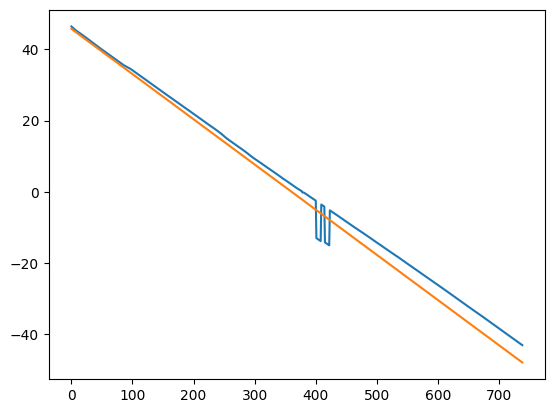

In [57]:
plt.plot(fa)
plt.plot([(-0.12711575238356873 * x + b) for x in np.arange(len(fa))])
plt.show()

In [76]:
rot = -a
angle = -rot*(378-0)+90
rotated = []

vidcap = cv2.VideoCapture(ROOT)

# total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
# total_frames = 3095-98

success, frame = vidcap.read()

vidcap.set(cv2.CAP_PROP_POS_FRAMES, 830)

out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/for_calibration.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*'mp4v'),
                      fps=60.0,
                      frameSize=(X2-X1, Y2-Y1),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ]
                      )

for i in tqdm(range(830, 1570, 1), desc="Processing frames"):
    success, frame = vidcap.read()
    frame = frame[Y1 - PADDING:Y2 + PADDING, X1 - PADDING:X2 + PADDING]
    rotate_matrix = cv2.getRotationMatrix2D((frame.shape[1] / 2, frame.shape[0] / 2), angle, 1)
    rotated_image = cv2.warpAffine(
        src=frame, M=rotate_matrix, dsize=(frame.shape[1], frame.shape[0]))[PADDING:Y2 - Y1 + PADDING,
                    PADDING:X2 - X1 + PADDING, 0]
    out.write(rotated_image.astype(np.uint8))
    
    angle += rot
    
out.release()

Processing frames:   0%|          | 0/740 [00:00<?, ?it/s]

In [5]:
output_path = '/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/'
with timing("Total OIO Pipeline"):
    video_file_path = '/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/for_calibration.mp4'

    with timing("VideoMotion"):
        motions = VideoMotion(video_file_path, output_path)
        motions.process()

    with timing("RowBuilder"):
        construct_rows(motions, video_file_path, output_path)

Processing VideoMotion for: /Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/for_calibration.mp4



Processing motion from frames:   0%|          | 0/740 [00:00<?, ?it/s]

Intervals: [[  0. 738.]] Calculated
Horizontal speed: 4.377765217926276±0.42537122564938046
Vertical shift: nan±nan
Clockwise: CCW, Portrait: False
Calculated

Unable to read frame: 771
Frames per 360: nan calculated from frame_shift: 671
VideoMotion: 5.9375 seconds
Processing RowBuilder for: /Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/for_calibration.mp4



C:\Users\fathe\OneDrive\Documents\UK\MFF\Thesis\zavity\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\fathe\OneDrive\Documents\UK\MFF\Thesis\zavity\venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\fathe\OneDrive\Documents\UK\MFF\Thesis\zavity\venv\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\fathe\OneDrive\Documents\UK\MFF\Thesis\zavity\venv\Lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\fathe\OneDrive\Documents\UK\MFF\Thesis\zavity\venv\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  

ValueError: cannot convert float NaN to integer

In [6]:
frames = []

for start, end in breakpoints:
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
    success, frame = vidcap.read()
    while success and vidcap.get(cv2.CAP_PROP_POS_FRAMES) <= end:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)
        success, frame = vidcap.read()

vidcap.release()

In [7]:
# Define the dimensions of the checkerboard
CHECKERBOARD = (3, 3)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.
found = 0

for frame in tqdm(frames, desc=f"Images with found corners: {found}"):
    frame = np.where(frame < 170, 0, 255).astype(np.uint8)
    ret, corners = cv2.findChessboardCorners(frame, CHECKERBOARD, None)
    

    if ret:
        found += 1
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(frame, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        # frame = cv2.drawChessboardCorners(frame, CHECKERBOARD, corners2, ret)
        # Draw and display the corners
        # cv2.drawChessboardCorners(frame, CHECKERBOARD, corners2, ret)
        # cv2.imshow('img', frame)
        # cv2.waitKey(500)

Images with found corners: 0:   0%|          | 0/1632 [00:00<?, ?it/s]

In [8]:
len(objpoints)

34

In [10]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, frame.shape[::-1], None, None)


In [55]:
np.save("mtx.npy", mtx)
np.save("dist.npy", dist)
np.save("rvecs.npy", rvecs)
np.save("tvecs.npy", tvecs)


In [39]:
frame = frames[1400]
h, w = frame.shape[:2]
new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
undistorted_frame = cv2.undistort(frame, mtx, dist, None, new_camera_mtx)
# Crop and save
x, y, w, h = roi
undistorted_frame2 = undistorted_frame[y:y+h, x:x+w]

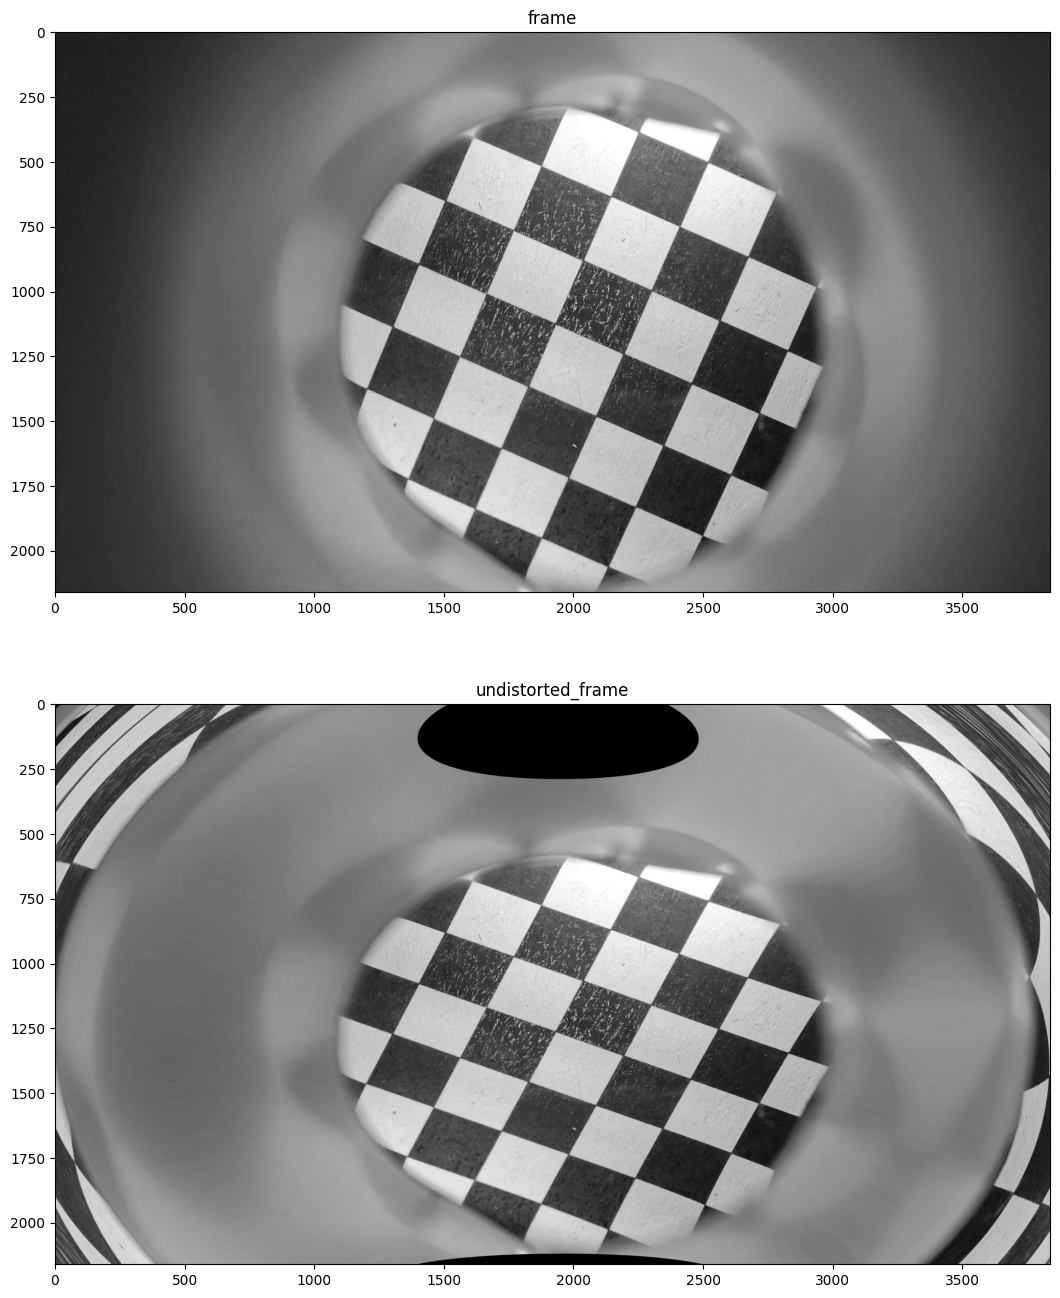

In [40]:
plt.figure(figsize=(16, 16))
ax = plt.subplot(211)
ax.imshow(frame, cmap="gray")
ax.set_title("frame")
ax = plt.subplot(212)
ax.imshow(undistorted_frame, cmap="gray")
ax.set_title("undistorted_frame")
plt.show()

In [51]:
y1 = 700
y2 = 1900
x1 = 1500
x2 = 2700

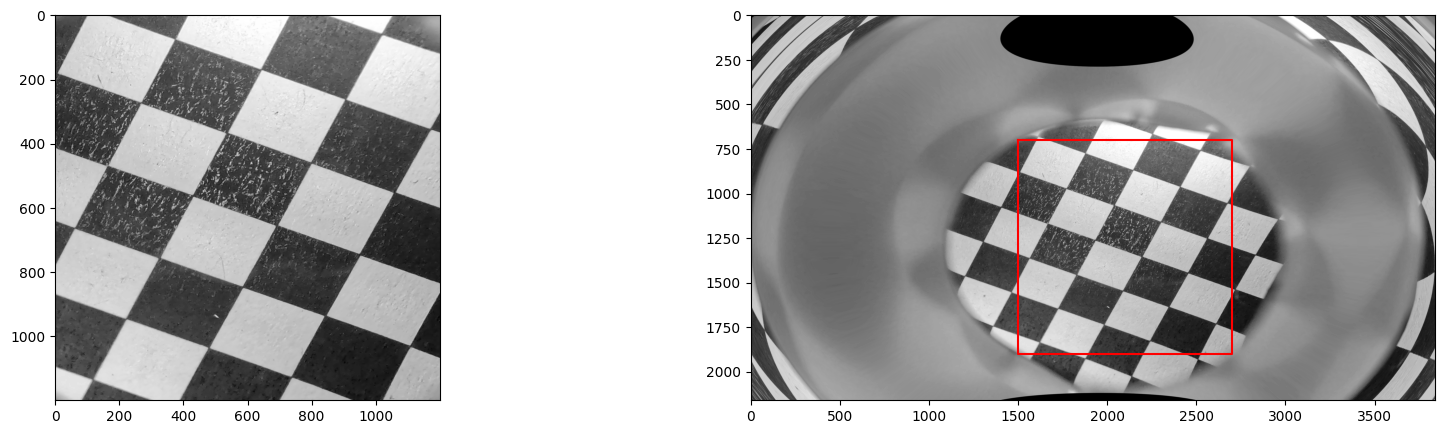

In [52]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(121)
ax.imshow(undistorted_frame[y1:y2, x1:x2], cmap="gray")
ax = plt.subplot(122)
ax.imshow(undistorted_frame, cmap="gray")
ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color="red")
plt.show()

In [22]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
 
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.2983097495615859


In [ ]:
for 